['Soekarno', 'Suharto', 'Baharuddin Jusuf Habibie', 'Abdurrahman Wahid', 'Megawati Sukarnoputri', 'Susilo Bambang Yudhoyono', 'Joko Widodo', 'Prabowo Subianto', 'Anies Rasyid Baswedan', 'Ganjar Pranowo', 'Gibran Rakabuming Raka', 'Maruf Amin', 'Airlangga Hartarto', 'Sri Mulyani Indrawati', 'Erick Thohir', 'Agus Harimurti Yudhoyono', 'Muhaimin Iskandar', 'Mahfud MD', 'Boediono', 'Jusuf Kalla']
Using device: cuda
PyTorch Version: 2.8.0.dev20250507+cu128, CUDA Version: 12.8
Loading preprocessed identity data from cache: C:/Users/yehte/Downloads/Ye Htet/Projects/TikTok/Annotation/fine-tune/train.identity_cached.csv
Loading preprocessed identity data from cache: C:/Users/yehte/Downloads/Ye Htet/Projects/TikTok/Annotation/fine-tune/valid.identity_cached.csv


Epoch 1/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.97it/s]


✅ Epoch 1: Train Loss=1.3503, Val Loss=0.9726, Train Acc=70.86%, Val Acc=68.50%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 2/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.46it/s]


✅ Epoch 2: Train Loss=0.7532, Val Loss=0.6227, Train Acc=90.14%, Val Acc=82.50%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 3/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.48it/s]


✅ Epoch 3: Train Loss=0.4188, Val Loss=0.4352, Train Acc=96.43%, Val Acc=91.00%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 4/100 [Val]: 100%|██████████| 7/7 [00:01<00:00,  3.61it/s]


✅ Epoch 4: Train Loss=0.2283, Val Loss=0.3225, Train Acc=99.14%, Val Acc=94.00%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 5/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.44it/s]


✅ Epoch 5: Train Loss=0.1285, Val Loss=0.2721, Train Acc=99.86%, Val Acc=95.50%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 6/100 [Val]: 100%|██████████| 7/7 [00:01<00:00,  3.55it/s]


✅ Epoch 6: Train Loss=0.0783, Val Loss=0.2406, Train Acc=100.00%, Val Acc=95.50%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 7/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.43it/s]


✅ Epoch 7: Train Loss=0.0532, Val Loss=0.2252, Train Acc=100.00%, Val Acc=95.50%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 8/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.37it/s]


✅ Epoch 8: Train Loss=0.0380, Val Loss=0.2099, Train Acc=100.00%, Val Acc=96.00%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 9/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.41it/s]


✅ Epoch 9: Train Loss=0.0290, Val Loss=0.2028, Train Acc=100.00%, Val Acc=96.00%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 10/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.43it/s]


✅ Epoch 10: Train Loss=0.0229, Val Loss=0.1949, Train Acc=100.00%, Val Acc=96.00%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 11/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.43it/s]


✅ Epoch 11: Train Loss=0.0189, Val Loss=0.1893, Train Acc=100.00%, Val Acc=96.00%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 12/100 [Val]: 100%|██████████| 7/7 [00:01<00:00,  3.51it/s]


✅ Epoch 12: Train Loss=0.0157, Val Loss=0.1857, Train Acc=100.00%, Val Acc=96.00%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 13/100 [Val]: 100%|██████████| 7/7 [00:03<00:00,  2.33it/s]


✅ Epoch 13: Train Loss=0.0133, Val Loss=0.1813, Train Acc=100.00%, Val Acc=96.00%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 14/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.75it/s]


✅ Epoch 14: Train Loss=0.0116, Val Loss=0.1783, Train Acc=100.00%, Val Acc=96.00%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 15/100 [Val]: 100%|██████████| 7/7 [00:03<00:00,  2.22it/s]


✅ Epoch 15: Train Loss=0.0101, Val Loss=0.1768, Train Acc=100.00%, Val Acc=96.00%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 16/100 [Val]: 100%|██████████| 7/7 [00:03<00:00,  2.25it/s]


✅ Epoch 16: Train Loss=0.0089, Val Loss=0.1734, Train Acc=100.00%, Val Acc=96.00%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 17/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.84it/s]


✅ Epoch 17: Train Loss=0.0079, Val Loss=0.1721, Train Acc=100.00%, Val Acc=96.00%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 18/100 [Val]: 100%|██████████| 7/7 [00:01<00:00,  3.53it/s]


✅ Epoch 18: Train Loss=0.0071, Val Loss=0.1695, Train Acc=100.00%, Val Acc=96.00%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 19/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.83it/s]


✅ Epoch 19: Train Loss=0.0064, Val Loss=0.1682, Train Acc=100.00%, Val Acc=96.00%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 20/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


✅ Epoch 20: Train Loss=0.0058, Val Loss=0.1676, Train Acc=100.00%, Val Acc=96.00%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 21/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


✅ Epoch 21: Train Loss=0.0053, Val Loss=0.1658, Train Acc=100.00%, Val Acc=96.00%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 22/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.45it/s]


✅ Epoch 22: Train Loss=0.0049, Val Loss=0.1645, Train Acc=100.00%, Val Acc=96.00%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 23/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.48it/s]


✅ Epoch 23: Train Loss=0.0045, Val Loss=0.1635, Train Acc=100.00%, Val Acc=96.00%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 24/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.47it/s]


✅ Epoch 24: Train Loss=0.0042, Val Loss=0.1627, Train Acc=100.00%, Val Acc=96.00%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 25/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.30it/s]


✅ Epoch 25: Train Loss=0.0039, Val Loss=0.1616, Train Acc=100.00%, Val Acc=96.00%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 26/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.47it/s]


✅ Epoch 26: Train Loss=0.0036, Val Loss=0.1609, Train Acc=100.00%, Val Acc=96.00%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 27/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.38it/s]


✅ Epoch 27: Train Loss=0.0033, Val Loss=0.1597, Train Acc=100.00%, Val Acc=96.00%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 28/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.47it/s]


✅ Epoch 28: Train Loss=0.0031, Val Loss=0.1590, Train Acc=100.00%, Val Acc=96.00%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 29/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.49it/s]


✅ Epoch 29: Train Loss=0.0029, Val Loss=0.1585, Train Acc=100.00%, Val Acc=96.00%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 30/100 [Val]: 100%|██████████| 7/7 [00:01<00:00,  3.54it/s]


✅ Epoch 30: Train Loss=0.0028, Val Loss=0.1583, Train Acc=100.00%, Val Acc=96.00%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 31/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.47it/s]


✅ Epoch 31: Train Loss=0.0026, Val Loss=0.1575, Train Acc=100.00%, Val Acc=96.00%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 32/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.46it/s]


✅ Epoch 32: Train Loss=0.0025, Val Loss=0.1563, Train Acc=100.00%, Val Acc=96.00%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 33/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.47it/s]


✅ Epoch 33: Train Loss=0.0023, Val Loss=0.1565, Train Acc=100.00%, Val Acc=96.00%
⚠️ No improvement. Patience: 1/5


Epoch 34/100 [Val]: 100%|██████████| 7/7 [00:01<00:00,  3.56it/s]


✅ Epoch 34: Train Loss=0.0022, Val Loss=0.1558, Train Acc=100.00%, Val Acc=96.00%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 35/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.48it/s]


✅ Epoch 35: Train Loss=0.0021, Val Loss=0.1551, Train Acc=100.00%, Val Acc=96.00%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 36/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.46it/s]


✅ Epoch 36: Train Loss=0.0020, Val Loss=0.1548, Train Acc=100.00%, Val Acc=96.00%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 37/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.40it/s]


✅ Epoch 37: Train Loss=0.0019, Val Loss=0.1542, Train Acc=100.00%, Val Acc=96.00%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 38/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.37it/s]


✅ Epoch 38: Train Loss=0.0018, Val Loss=0.1540, Train Acc=100.00%, Val Acc=96.00%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 39/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.14it/s]


✅ Epoch 39: Train Loss=0.0017, Val Loss=0.1536, Train Acc=100.00%, Val Acc=96.00%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 40/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.13it/s]


✅ Epoch 40: Train Loss=0.0016, Val Loss=0.1535, Train Acc=100.00%, Val Acc=96.00%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 41/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.50it/s]


✅ Epoch 41: Train Loss=0.0016, Val Loss=0.1529, Train Acc=100.00%, Val Acc=96.00%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 42/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


✅ Epoch 42: Train Loss=0.0015, Val Loss=0.1524, Train Acc=100.00%, Val Acc=96.00%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 43/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.42it/s]


✅ Epoch 43: Train Loss=0.0014, Val Loss=0.1525, Train Acc=100.00%, Val Acc=96.00%
⚠️ No improvement. Patience: 1/5


Epoch 44/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.39it/s]


✅ Epoch 44: Train Loss=0.0014, Val Loss=0.1520, Train Acc=100.00%, Val Acc=96.00%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 45/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


✅ Epoch 45: Train Loss=0.0013, Val Loss=0.1518, Train Acc=100.00%, Val Acc=96.00%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 46/100 [Val]: 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]


✅ Epoch 46: Train Loss=0.0013, Val Loss=0.1513, Train Acc=100.00%, Val Acc=96.00%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 47/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.54it/s]


✅ Epoch 47: Train Loss=0.0012, Val Loss=0.1511, Train Acc=100.00%, Val Acc=96.00%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 48/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


✅ Epoch 48: Train Loss=0.0012, Val Loss=0.1508, Train Acc=100.00%, Val Acc=96.00%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 49/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.86it/s]


✅ Epoch 49: Train Loss=0.0011, Val Loss=0.1507, Train Acc=100.00%, Val Acc=96.00%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 50/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


✅ Epoch 50: Train Loss=0.0011, Val Loss=0.1504, Train Acc=100.00%, Val Acc=96.00%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 51/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.96it/s]


✅ Epoch 51: Train Loss=0.0010, Val Loss=0.1501, Train Acc=100.00%, Val Acc=96.00%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 52/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.41it/s]


✅ Epoch 52: Train Loss=0.0010, Val Loss=0.1499, Train Acc=100.00%, Val Acc=96.00%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 53/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.36it/s]


✅ Epoch 53: Train Loss=0.0010, Val Loss=0.1498, Train Acc=100.00%, Val Acc=96.00%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 54/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.40it/s]


✅ Epoch 54: Train Loss=0.0009, Val Loss=0.1497, Train Acc=100.00%, Val Acc=96.00%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 55/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.53it/s]


✅ Epoch 55: Train Loss=0.0009, Val Loss=0.1496, Train Acc=100.00%, Val Acc=96.00%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 56/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.29it/s]


✅ Epoch 56: Train Loss=0.0009, Val Loss=0.1491, Train Acc=100.00%, Val Acc=96.00%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 57/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.35it/s]


✅ Epoch 57: Train Loss=0.0008, Val Loss=0.1491, Train Acc=100.00%, Val Acc=96.00%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 58/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.40it/s]


✅ Epoch 58: Train Loss=0.0008, Val Loss=0.1487, Train Acc=100.00%, Val Acc=96.00%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 59/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.35it/s]


✅ Epoch 59: Train Loss=0.0008, Val Loss=0.1485, Train Acc=100.00%, Val Acc=96.00%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 60/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.36it/s]


✅ Epoch 60: Train Loss=0.0008, Val Loss=0.1484, Train Acc=100.00%, Val Acc=96.00%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 61/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.82it/s]


✅ Epoch 61: Train Loss=0.0007, Val Loss=0.1482, Train Acc=100.00%, Val Acc=96.00%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 62/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.69it/s]


✅ Epoch 62: Train Loss=0.0007, Val Loss=0.1483, Train Acc=100.00%, Val Acc=96.00%
⚠️ No improvement. Patience: 1/5


Epoch 63/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.85it/s]


✅ Epoch 63: Train Loss=0.0007, Val Loss=0.1480, Train Acc=100.00%, Val Acc=96.00%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 64/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


✅ Epoch 64: Train Loss=0.0007, Val Loss=0.1479, Train Acc=100.00%, Val Acc=96.00%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 65/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.85it/s]


✅ Epoch 65: Train Loss=0.0007, Val Loss=0.1478, Train Acc=100.00%, Val Acc=96.00%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 66/100 [Val]: 100%|██████████| 7/7 [00:03<00:00,  2.32it/s]


✅ Epoch 66: Train Loss=0.0006, Val Loss=0.1475, Train Acc=100.00%, Val Acc=96.00%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 67/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.53it/s]


✅ Epoch 67: Train Loss=0.0006, Val Loss=0.1475, Train Acc=100.00%, Val Acc=96.00%
⚠️ No improvement. Patience: 1/5


Epoch 68/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.40it/s]


✅ Epoch 68: Train Loss=0.0006, Val Loss=0.1474, Train Acc=100.00%, Val Acc=96.00%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 69/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.43it/s]


✅ Epoch 69: Train Loss=0.0006, Val Loss=0.1470, Train Acc=100.00%, Val Acc=96.00%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 70/100 [Val]: 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]


✅ Epoch 70: Train Loss=0.0006, Val Loss=0.1469, Train Acc=100.00%, Val Acc=96.00%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 71/100 [Val]: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


✅ Epoch 71: Train Loss=0.0006, Val Loss=0.1469, Train Acc=100.00%, Val Acc=96.00%
⚠️ No improvement. Patience: 1/5


Epoch 72/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.39it/s]


✅ Epoch 72: Train Loss=0.0005, Val Loss=0.1468, Train Acc=100.00%, Val Acc=96.00%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 73/100 [Val]: 100%|██████████| 7/7 [00:03<00:00,  2.06it/s]


✅ Epoch 73: Train Loss=0.0005, Val Loss=0.1467, Train Acc=100.00%, Val Acc=96.00%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 74/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.85it/s]


✅ Epoch 74: Train Loss=0.0005, Val Loss=0.1466, Train Acc=100.00%, Val Acc=96.00%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 75/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]


✅ Epoch 75: Train Loss=0.0005, Val Loss=0.1466, Train Acc=100.00%, Val Acc=95.50%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 76/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.85it/s]


✅ Epoch 76: Train Loss=0.0005, Val Loss=0.1463, Train Acc=100.00%, Val Acc=96.00%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 77/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.73it/s]


✅ Epoch 77: Train Loss=0.0005, Val Loss=0.1463, Train Acc=100.00%, Val Acc=96.00%
⚠️ No improvement. Patience: 1/5


Epoch 78/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.85it/s]


✅ Epoch 78: Train Loss=0.0005, Val Loss=0.1462, Train Acc=100.00%, Val Acc=95.50%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 79/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.45it/s]


✅ Epoch 79: Train Loss=0.0004, Val Loss=0.1461, Train Acc=100.00%, Val Acc=96.00%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 80/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.46it/s]


✅ Epoch 80: Train Loss=0.0004, Val Loss=0.1460, Train Acc=100.00%, Val Acc=95.50%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 81/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.47it/s]


✅ Epoch 81: Train Loss=0.0004, Val Loss=0.1460, Train Acc=100.00%, Val Acc=95.50%
⚠️ No improvement. Patience: 1/5


Epoch 82/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.41it/s]


✅ Epoch 82: Train Loss=0.0004, Val Loss=0.1459, Train Acc=100.00%, Val Acc=95.50%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 83/100 [Val]: 100%|██████████| 7/7 [00:03<00:00,  2.11it/s]


✅ Epoch 83: Train Loss=0.0004, Val Loss=0.1456, Train Acc=100.00%, Val Acc=95.50%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 84/100 [Val]: 100%|██████████| 7/7 [00:03<00:00,  2.27it/s]


✅ Epoch 84: Train Loss=0.0004, Val Loss=0.1457, Train Acc=100.00%, Val Acc=95.50%
⚠️ No improvement. Patience: 1/5


Epoch 85/100 [Val]: 100%|██████████| 7/7 [00:03<00:00,  2.26it/s]


✅ Epoch 85: Train Loss=0.0004, Val Loss=0.1457, Train Acc=100.00%, Val Acc=95.50%
⚠️ No improvement. Patience: 2/5


Epoch 86/100 [Val]: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


✅ Epoch 86: Train Loss=0.0004, Val Loss=0.1456, Train Acc=100.00%, Val Acc=95.50%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 87/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.61it/s]


✅ Epoch 87: Train Loss=0.0004, Val Loss=0.1455, Train Acc=100.00%, Val Acc=95.50%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 88/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.81it/s]


✅ Epoch 88: Train Loss=0.0004, Val Loss=0.1453, Train Acc=100.00%, Val Acc=95.50%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 89/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.70it/s]


✅ Epoch 89: Train Loss=0.0004, Val Loss=0.1453, Train Acc=100.00%, Val Acc=95.50%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 90/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.75it/s]


✅ Epoch 90: Train Loss=0.0003, Val Loss=0.1452, Train Acc=100.00%, Val Acc=95.50%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 91/100 [Val]: 100%|██████████| 7/7 [00:03<00:00,  2.26it/s]


✅ Epoch 91: Train Loss=0.0003, Val Loss=0.1451, Train Acc=100.00%, Val Acc=95.50%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 92/100 [Val]: 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


✅ Epoch 92: Train Loss=0.0003, Val Loss=0.1452, Train Acc=100.00%, Val Acc=95.50%
⚠️ No improvement. Patience: 1/5


Epoch 93/100 [Val]: 100%|██████████| 7/7 [00:03<00:00,  2.32it/s]


✅ Epoch 93: Train Loss=0.0003, Val Loss=0.1452, Train Acc=100.00%, Val Acc=95.50%
⚠️ No improvement. Patience: 2/5


Epoch 94/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.45it/s]


✅ Epoch 94: Train Loss=0.0003, Val Loss=0.1449, Train Acc=100.00%, Val Acc=95.50%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 95/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]


✅ Epoch 95: Train Loss=0.0003, Val Loss=0.1448, Train Acc=100.00%, Val Acc=95.50%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 96/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.52it/s]


✅ Epoch 96: Train Loss=0.0003, Val Loss=0.1448, Train Acc=100.00%, Val Acc=95.50%
⚠️ No improvement. Patience: 1/5


Epoch 97/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


✅ Epoch 97: Train Loss=0.0003, Val Loss=0.1448, Train Acc=100.00%, Val Acc=95.50%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 98/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.46it/s]


✅ Epoch 98: Train Loss=0.0003, Val Loss=0.1448, Train Acc=100.00%, Val Acc=95.50%
⚠️ No improvement. Patience: 1/5


Epoch 99/100 [Val]: 100%|██████████| 7/7 [00:01<00:00,  3.52it/s]


✅ Epoch 99: Train Loss=0.0003, Val Loss=0.1447, Train Acc=100.00%, Val Acc=95.50%
🎉 Saved best model to finetuned_identity_only_best_ViT-B-16_openai_7_11.pt


Epoch 100/100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.36it/s]


✅ Epoch 100: Train Loss=0.0003, Val Loss=0.1448, Train Acc=100.00%, Val Acc=95.50%
⚠️ No improvement. Patience: 1/5


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/yehte/Downloads/Ye Htet/Projects/TikTok/zero_shot_face_recognition/fourth_discussion/test_results_identity_only_ViT-B-16_openai_7_11\\training_history.png'

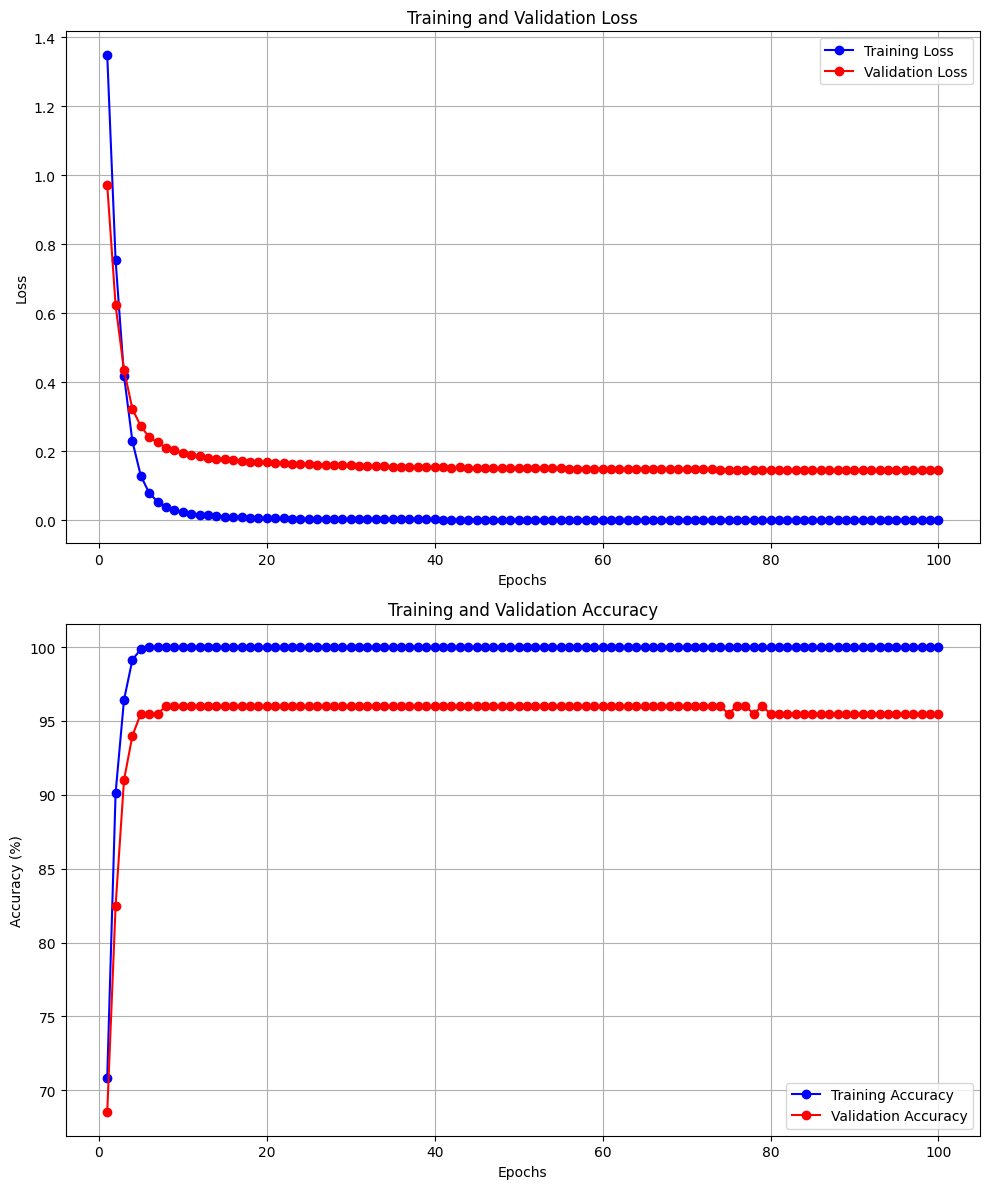

In [1]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import open_clip
from tqdm import tqdm
import matplotlib.pyplot as plt
import textwrap
import re
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from pathlib import Path

# ------------------------------
# DEBUGGING & CONFIGURATION
# ------------------------------
# This forces CUDA operations to be synchronous for accurate error reporting.
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

CONFIG = {
    "model_name": "ViT-B-16-quickgelu",
    "pretrained": "openai",
    "csv_train": "C:/Users/yehte/Downloads/Ye Htet/Projects/TikTok/Annotation/fine-tune/train.csv",
    "csv_val": "C:/Users/yehte/Downloads/Ye Htet/Projects/TikTok/Annotation/fine-tune/valid.csv",
    "csv_test": "C:/Users/yehte/Downloads/Ye Htet/Projects/TikTok/Annotation/fine-tune/test.csv",
    "save_path": "finetuned_identity_only_best_ViT-B-16_openai_7_11.pt",
    "plot_save_dir": "C:/Users/yehte/Downloads/Ye Htet/Projects/TikTok/zero_shot_face_recognition/fourth_discussion",
    "result_save_dir": "C:/Users/yehte/Downloads/Ye Htet/Projects/TikTok/zero_shot_face_recognition/fourth_discussion/test_results_identity_only_ViT-B-16_openai_7_11",
    "num_plots": 100,
    "batch_size": 32,
    "epochs": 100,
    "lr": 1e-6,
    "patience": 5,
    "device": "cuda" if torch.cuda.is_available() else "cpu",

    # --- SIMPLIFIED: Prompts for Identity ONLY ---
    "identity_prompts": [
        "A face of Soekarno, a male First President (1945-1967) from Indonesia.",
        "A face of Suharto, a male Second President (1967-1998) from Indonesia.",
        "A face of Baharuddin Jusuf Habibie, a male Third President (1998-1999) from Indonesia.",
        "A face of Abdurrahman Wahid, a male Fourth President (1999-2001) from Indonesia.",
        "A face of Megawati Sukarnoputri, a female Fifth President (2001-2004) from Indonesia.",
        "A face of Susilo Bambang Yudhoyono, a male Sixth President (2004-2014) from Indonesia.",
        "A face of Joko Widodo, a male Seventh President (2014-2024) from Indonesia.",
        "A face of Prabowo Subianto, a male Eight President (2024-Present) from Indonesia.",
        "A face of Anies Rasyid Baswedan, a male Governor of Jakarta (2017-2022) and Presidential Candidate Election (2024) from Indonesia.",
        "A face of Ganjar Pranowo, a male Governor of Central Java (2013-2023) and Presidential Candidate Election (2024) from Indonesia.",
        "A face of Gibran Rakabuming Raka, a male Vice President (2024-2029) from Indonesia.",
        "A face of Maruf Amin, a male Vice President (2019-2024) from Indonesia.",
        "A face of Airlangga Hartarto, a male Coordinating Minister of Economic Affairs (2024-2029) from Indonesia.",
        "A face of Sri Mulyani Indrawati, a female Minister of Finance (2024-2029) from Indonesia.",
        "A face of Erick Thohir, a male Minister of State Owned Entreprises (2024-2029) from Indonesia.",
        "A face of Agus Harimurti Yudhoyono, a male Coordinating Minister of Agrarian Affairs and Spatial Planning (2024-2029) and Chairman of Democratic Party from Indonesia.",
        "A face of Muhaimin Iskandar, a male Coordinating Minister of Social Empowrement (2024-2029) and Chairman of National Awakening Party from Indonesia.",
        "A face of Mahfud MD, a male Coordinating Minister of Political, Legal, and Security Affairs (2019-2024) from Indonesia.",
        "A face of Boediono, a male Vice President (2009-2014) from Indonesia.",
        "A face of Jusuf Kalla, a male Vice President (2004-2009) and Vice President (2014-2019) from Indonesia."
    ]
}

# --- Create simplified keys from prompts for mapping ---
CONFIG["identity_keys"] = [p.replace("A face of ", "").split(",")[0] for p in CONFIG["identity_prompts"]]
print(CONFIG["identity_keys"])

# ------------------------------
# Helper Function for Parsing
# ------------------------------
def parse_identity_from_prompt(prompt_text):
    """
    A more robust parser to find any of the identity keys in the prompt
    using word boundaries to ensure exact matches.
    """
    for name in CONFIG["identity_keys"]:
        if re.search(r'\b' + re.escape(name) + r'\b', prompt_text, re.IGNORECASE):
            return name
    return None

# ------------------------------
# Preprocessing and Caching
# ------------------------------
def preprocess_and_cache_csv(csv_path):
    """
    Parses prompts for identity and saves a cached version.
    """
    cache_path = csv_path.replace(".csv", ".identity_cached.csv")
    if os.path.exists(cache_path):
        print(f"Loading preprocessed identity data from cache: {cache_path}")
        try:
            df_cache = pd.read_csv(cache_path)
            if df_cache.empty:
                 print("Warning: Cached file is empty. Reprocessing.")
            else:
                return df_cache
        except pd.errors.EmptyDataError:
            print(f"Warning: Cached file is empty. Reprocessing.")

    print(f"Preprocessing identity data and caching: {csv_path}")
    try:
        df = pd.read_csv(csv_path)
    except (FileNotFoundError, pd.errors.EmptyDataError):
        print(f"Error or empty file at {csv_path}")
        return None

    new_data = []
    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Preprocessing {os.path.basename(csv_path)}"):
        name = parse_identity_from_prompt(row['prompt'])
        if name:
            new_data.append({
                'filepath': row['filepath'],
                'prompt': row['prompt'],
                'identity_idx': CONFIG["identity_keys"].index(name)
            })

    if not new_data:
        print("Warning: Preprocessing resulted in an empty dataset.")
        return None

    cached_df = pd.DataFrame(new_data)
    cached_df.to_csv(cache_path, index=False)
    return cached_df

# ------------------------------
# Dataset Class
# ------------------------------
class IdentityDataset(Dataset):
    def __init__(self, df, preprocess):
        self.df = df if df is not None else pd.DataFrame()
        self.preprocess = preprocess

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = row["filepath"]
        try:
            image = Image.open(image_path).convert("RGB")
            image = self.preprocess(image)
        except FileNotFoundError:
            image = torch.zeros((3, 224, 224))

        identity_idx = torch.tensor(row["identity_idx"])
        return image, identity_idx, image_path

# ------------------------------
# Training and Evaluation Functions
# ------------------------------
def plot_history(history, save_dir):
    """Plots and saves the training and validation loss and accuracy."""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

    epochs_range = range(1, len(history['train_loss']) + 1)

    ax1.plot(epochs_range, history['train_loss'], 'bo-', label='Training Loss')
    ax1.plot(epochs_range, history['val_loss'], 'ro-', label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(epochs_range, history['train_acc'], 'bo-', label='Training Accuracy')
    ax2.plot(epochs_range, history['val_acc'], 'ro-', label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    save_path = os.path.join(save_dir, "training_history.png")
    plt.savefig(save_path)
    plt.close(fig)
    print(f"Training history plot saved to: {save_path}")

def train_and_validate(model, train_loader, val_loader, identity_text_features):
    optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG["lr"])
    loss_fn = torch.nn.CrossEntropyLoss()
    best_val_loss = float("inf")
    patience_counter = 0
    model_saved = False

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(CONFIG["epochs"]):
        model.train()
        total_train_loss = 0
        for images, gt_indices, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{CONFIG['epochs']} [Train]"):
            images, gt_indices = images.to(CONFIG["device"]), gt_indices.to(CONFIG["device"])

            image_features = model.encode_image(images)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            logits_per_image = (100.0 * image_features @ identity_text_features.T)
            loss = loss_fn(logits_per_image, gt_indices)

            optimizer.zero_grad(); loss.backward(); optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        model.eval()
        total_val_loss = 0
        correct_train, total_train = 0, 0
        correct_val, total_val = 0, 0

        with torch.no_grad():
            # Calculate training accuracy
            for images, gt_indices, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{CONFIG['epochs']} [Train Acc]"):
                images, gt_indices = images.to(CONFIG["device"]), gt_indices.to(CONFIG["device"])
                image_features = model.encode_image(images)
                image_features /= image_features.norm(dim=-1, keepdim=True)
                logits_per_image = (100.0 * image_features @ identity_text_features.T)
                preds = logits_per_image.argmax(dim=-1)
                total_train += gt_indices.size(0)
                correct_train += (preds == gt_indices).sum().item()

            # Calculate validation loss and accuracy
            for images, gt_indices, _ in tqdm(val_loader, desc=f"Epoch {epoch+1}/{CONFIG['epochs']} [Val]"):
                images, gt_indices = images.to(CONFIG["device"]), gt_indices.to(CONFIG["device"])
                image_features = model.encode_image(images)
                image_features /= image_features.norm(dim=-1, keepdim=True)
                logits_per_image = (100.0 * image_features @ identity_text_features.T)
                loss = loss_fn(logits_per_image, gt_indices)
                total_val_loss += loss.item()

                preds = logits_per_image.argmax(dim=-1)
                total_val += gt_indices.size(0)
                correct_val += (preds == gt_indices).sum().item()

        avg_val_loss = total_val_loss / len(val_loader)
        train_acc = (correct_train / total_train) * 100
        val_acc = (correct_val / total_val) * 100

        history['val_loss'].append(avg_val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"✅ Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}, Train Acc={train_acc:.2f}%, Val Acc={val_acc:.2f}%")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), CONFIG["save_path"])
            print(f"🎉 Saved best model to {CONFIG['save_path']}")
            patience_counter = 0
            model_saved = True
        else:
            patience_counter += 1
            print(f"⚠️ No improvement. Patience: {patience_counter}/{CONFIG['patience']}")
        if patience_counter >= CONFIG["patience"]:
            print("🛑 Early stopping triggered."); break

    plot_history(history, CONFIG["plot_save_dir"])
    return model_saved


def test_and_plot(model, identity_text_features, preprocess):
    print("\n--- Starting Final Testing and Plotting Phase ---")
    model.load_state_dict(torch.load(CONFIG["save_path"])); model.to(CONFIG["device"]).eval()
    print("Best model loaded.")

    test_df = preprocess_and_cache_csv(CONFIG["csv_test"])
    if test_df is None or test_df.empty:
        print("Halting due to empty or missing test dataset.")
        return

    test_dataset = IdentityDataset(test_df, preprocess)
    test_loader = DataLoader(test_dataset, batch_size=CONFIG["batch_size"], shuffle=False)

    correct_predictions, total_samples = 0, 0
    all_results = []
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, gt_indices, image_paths in tqdm(test_loader, desc="[Testing]"):
            images = images.to(CONFIG["device"])
            image_features = model.encode_image(images)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            logits = (100.0 * image_features @ identity_text_features.T)
            preds = logits.argmax(dim=-1)

            y_true.extend(gt_indices.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

            for i in range(len(images)):
                is_correct = (preds[i] == gt_indices[i]).item()
                if is_correct: correct_predictions += 1
                all_results.append({
                    "image_path": image_paths[i],
                    "ground_truth": CONFIG["identity_keys"][gt_indices[i]],
                    "prediction": CONFIG["identity_keys"][preds[i]],
                    "is_correct": is_correct
                })
            total_samples += len(images)

    if total_samples > 0:
        accuracy = (correct_predictions / total_samples) * 100
        print(f"\n📊 Test Accuracy: {accuracy:.2f}%")
    else:
        print("No valid samples were processed in the test set.")
        return

    print("\n--- Generating Confusion Matrix ---")
    os.makedirs(CONFIG["result_save_dir"], exist_ok=True)
    cm = confusion_matrix(y_true, y_pred, labels=range(len(CONFIG["identity_keys"])))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CONFIG["identity_keys"])
    fig, ax = plt.subplots(figsize=(20, 20))
    disp.plot(ax=ax, xticks_rotation='vertical', cmap='Blues')
    plt.title("Identity Classification Confusion Matrix")
    plt.tight_layout()
    cm_save_path = os.path.join(CONFIG["plot_save_dir"], "confusion_matrix.png")
    plt.savefig(cm_save_path)
    plt.close(fig)
    print(f"Confusion matrix saved to: {cm_save_path}")

    print(f"\n--- Plotting up to {CONFIG['num_plots']} individual results ---")
    for i, result in enumerate(all_results):
        if i >= CONFIG["num_plots"]: break
        try:
            img = Image.open(result["image_path"])
        except FileNotFoundError: continue

        fig, ax = plt.subplots(figsize=(8, 10))
        ax.imshow(img); ax.axis("off")
        title = f"Result {i+1}: {'CORRECT' if result['is_correct'] else 'INCORRECT'}"
        color = 'green' if result['is_correct'] else 'red'
        fig.suptitle(title, fontsize=16, color=color)
        text = (f"Ground Truth: {result['ground_truth']}\n"
                f"Prediction:   {result['prediction']}")
        ax.set_title(text, fontsize=12, pad=10)

        original_filename_stem = Path(result["image_path"]).stem
        status = "CORRECT" if result['is_correct'] else "INCORRECT"
        save_name = f"{original_filename_stem}_result_{status}.png"
        plt.savefig(os.path.join(CONFIG["plot_save_dir"], save_name), bbox_inches='tight')
        plt.close(fig)

    print("--- Plotting complete ---")

# ==============================
#      MAIN EXECUTION BLOCK
# ==============================
if __name__ == '__main__':
    print(f"Using device: {CONFIG['device']}")
    if torch.cuda.is_available():
        print(f"PyTorch Version: {torch.__version__}, CUDA Version: {torch.version.cuda}")

    model, _, preprocess = open_clip.create_model_and_transforms(
        CONFIG["model_name"], pretrained=CONFIG["pretrained"], device=CONFIG["device"]
    )
    tokenizer = open_clip.get_tokenizer(CONFIG["model_name"])

    with torch.no_grad():
        identity_text_tokens = tokenizer(CONFIG["identity_prompts"]).to(CONFIG["device"])
        identity_text_features = model.encode_text(identity_text_tokens)
        identity_text_features = identity_text_features / identity_text_features.norm(dim=-1, keepdim=True)

    train_df = preprocess_and_cache_csv(CONFIG["csv_train"])
    val_df = preprocess_and_cache_csv(CONFIG["csv_val"])

    if train_df is not None and val_df is not None and not train_df.empty and not val_df.empty:
        train_dataset = IdentityDataset(train_df, preprocess)
        val_dataset = IdentityDataset(val_df, preprocess)
        train_loader = DataLoader(train_dataset, batch_size=CONFIG["batch_size"], shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=CONFIG["batch_size"], shuffle=False)

        training_successful = train_and_validate(model, train_loader, val_loader, identity_text_features)

        if training_successful:
            test_and_plot(model, identity_text_features, preprocess)
        else:
            print("\nSkipping testing phase: No model was saved during training.")
    else:
        print("\nSkipping training: Training/validation datasets are empty or could not be loaded.")


In [2]:
test_and_plot(model, identity_text_features, preprocess)


--- Starting Final Testing and Plotting Phase ---
Best model loaded.
Loading preprocessed identity data from cache: C:/Users/yehte/Downloads/Ye Htet/Projects/TikTok/Annotation/fine-tune/test.identity_cached.csv


[Testing]: 100%|██████████| 4/4 [00:01<00:00,  3.48it/s]



📊 Test Accuracy: 97.00%

--- Generating Confusion Matrix ---
Confusion matrix saved to: C:/Users/yehte/Downloads/Ye Htet/Projects/TikTok/zero_shot_face_recognition/fourth_discussion/test_results_identity_only_ViT-B-16_openai_7_11\confusion_matrix.png

--- Plotting up to 100 individual results ---
--- Plotting complete ---
